In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import colormaps as cmaps
import os
import scipy as sp
from scipy.ndimage.interpolation import rotate
from magpie_data import NeLMap, OpticalFrames, PolarimetryMap, FaradayMap

# Figure 1: Setup

In [ ]:
cd "~\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns"

In [ ]:
s1026_15_532=NeLMap('s1026_15 532nm neL.txt', scale=173)
s1026_15_532.set_origin(origin=(1734,2449))

In [ ]:
s=s1026_15_532
fig, ax=plt.subplots(figsize=(8,8))
gim=s.plot_neL_mm(ax=ax, clim=[0,2],transpose=True)

ax.set_xlim([-4.4,4.4])
ax.set_ylim([-8,8])
ax.axis('off')

In [ ]:
fig.savefig("s1026_15 end on detail.pdf", dpi=300, bbox_inches='tight')

# Figure 2: Optical Framing

In [ ]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\2016\s0120B16 C RECONNECTION 12 FRAME\s0120B16

In [ ]:
s=OpticalFrames(188,15)
s.logarithm()
s.rotate(-90+25)
s.crop((634,597), xcrop=230, ycrop=300)

In [ ]:
fig, ax=plt.subplots(1,4,figsize=(14,8))
s.plot_crop(frame=1, ax=ax[0], clim=[0.1,0.8])
s.plot_crop(frame=2, ax=ax[1], clim=[0.1,0.8])
s.plot_crop(frame=5, ax=ax[2], clim=[0.2,0.8])
s.plot_crop(frame=11, ax=ax[3], clim=[0.5,1])
for a in ax:
    a.set_title('')

# Figure 3: Interferometry

In [2]:
%cd "~\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow


In [3]:
s1006_15_532=NeLMap('s1006_15 532nm neL.txt', scale=173, multiply_by=1/1.6)
s1006_15_532.set_origin(origin=(1760,2328))
s1006_15_355=NeLMap('s1006_15 355nm neL.txt', scale=128, multiply_by=2/1.6, flip_lr=True)
s1006_15_355.set_origin(origin=(1200,1680))

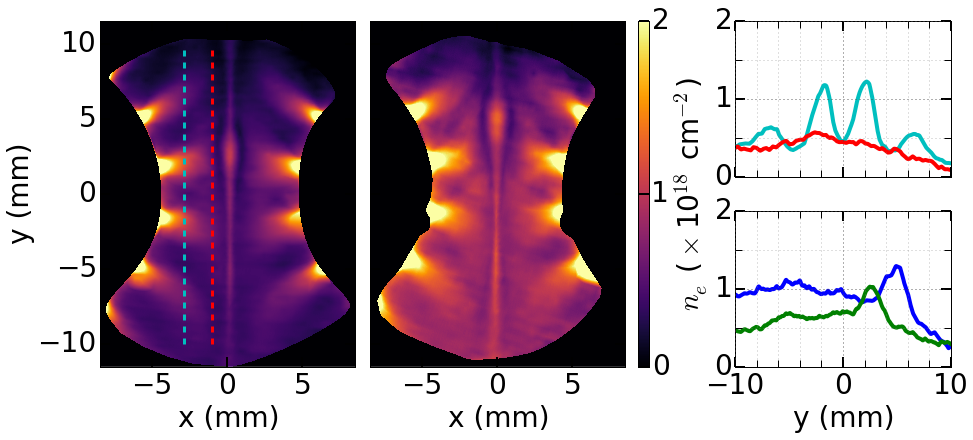

In [18]:
fig=plt.figure(figsize=(15, 6))
ax1=fig.add_axes([0.0, 0.10, 0.3, 0.8])#l,b,w,h
gim=s1006_15_532.plot_neL_mm(ax=ax1, clim=[0,2],transpose=True)

for x_mm in [-2.9,-1]:
    ax1.plot([x_mm,x_mm],[-10,10], lw=3, ls='dashed')
ax1.lines[0].set_color('c')
ax1.lines[1].set_color('red')

ax2=fig.add_axes([0.25, 0.10, 0.3, 0.8])#l,b,w,h
bim=s1006_15_355.plot_neL_mm(ax=ax2, clim=[0,2],transpose=True)

ax1.set_xlabel('x (mm)',fontsize=28)
ax1.set_ylabel('y (mm)',fontsize=28)
ax2.set_xlabel('x (mm)',fontsize=28)
ax2.set_xticks([-5,0,5])
ax1.set_xticks([-5,0,5])

ax1.set_xlim([-8.5,8.5])
ax1.set_ylim([-11.5,11.5])

ax1.tick_params(labelsize=28, pad=5, length=10, width=2)
ax2.tick_params(labelsize=28, pad=5, length=10, width=2)
plt.setp(ax2.get_yticklabels(), visible=False)

cbar_ax=fig.add_axes([0.53, 0.10, 0.01, 0.8])#l,b,w,h
cbar_ax.tick_params(labelsize=28, pad=5, length=10, width=2)

fig.colorbar(bim, cax=cbar_ax, ticks=[0.0,1,2])
cbar_ax.set_ylabel(r'$n_e$ ($\times$ 10$^{18}$ cm$^{-2}$)',fontsize=28)


ax4=fig.add_axes([0.62, 0.10, 0.2, 0.36])#l,b,w,h

s=s1006_15_355

s.create_lineout(axis=0,  mm_range=10)
s.plot_lineout(ax=ax4)

s=s1006_15_532

s.create_lineout(axis=0,  mm_range=10)
s.plot_lineout(ax=ax4)

 
ax4.set_xlim([-10,10])#
ax4.set_xticks([-10,0,10])#
ax4.xaxis.set_minor_locator(MultipleLocator(2))

ax4.set_ylim([0, 2])
ax4.set_yticks([0, 1,2])
ax4.yaxis.set_minor_locator(MultipleLocator(0.5))


ax4.set_xlabel('y (mm)',fontsize=28)
ax4.tick_params(which='minor', pad=5, length=7, width=1)
ax4.tick_params(labelsize=28, pad=5, length=10, width=2)

ax4.grid()
ax4.grid(which='minor', color='gray',linestyle=':')


ax3=fig.add_axes([0.62, 0.54, 0.2, 0.36], sharex=ax4)#l,b,w,h
s=s1006_15_532

for y_mm in [-2.9,-1]:
    y_px=s.origin[0]+y_mm*s.scale
    s.create_lineout(axis=0, centre=y_px, mm_range=10)
    s.plot_lineout(ax=ax3, label="x= "+str(y_mm)+" mm")
    
ax3.lines[0].set_color('c')
ax3.lines[1].set_color('red')

ax3.set_xticks([-10,0,10])
ax3.xaxis.set_minor_locator(MultipleLocator(2))
plt.setp(ax3.get_xticklabels(), visible=False)

ax3.set_ylim([0, 2])
ax3.set_yticks([0, 1,2])
ax3.yaxis.set_minor_locator(MultipleLocator(0.5))

ax3.grid()
ax3.grid(which='minor', color='gray',linestyle=':')


ax3.tick_params(which='minor', pad=5, length=7, width=1)
ax3.tick_params(labelsize=28, pad=5, length=10, width=2)

In [19]:
fig.savefig('s1006_15 nel maps with lineouts.pdf', dpi=300, bbox_inches='tight')

# Figure 4: Faraday
This one is quite involved, we do the full image registration.

In [20]:
cd "~\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat\s0513_15"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat\s0513_15


In [21]:
B0fn="13-May-2015 16_39_56_1355463638.png"
B1fn="13-May-2015 16_39_56_2211629970.png"
S0fn="13-May-2015 17_00_09_1355463638.png"
S1fn="13-May-2015 17_00_09_2211629970.png"
s0513_15_pol=PolarimetryMap(B0fn, B1fn, S0fn, S1fn)
s=s0513_15_pol

In [22]:
s.register()
s.convert_to_alpha()
s.scale=66
s.set_origin((1271,1680), x_range=6.5, y_range=8.5)

C:\Users\jdavies\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:180: RuntimeWarning: divide by zero encountered in true_divide
  self.N1=self.ST/self.BT
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:180: RuntimeWarning: invalid value encountered in true_divide
  self.N1=self.ST/self.BT
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:184: RuntimeWarning: invalid value encountered in arcsin
  self.alpha=(180/np.pi)*0.5*np.arcsin(self.diff*np.tan(beta)/2.0)


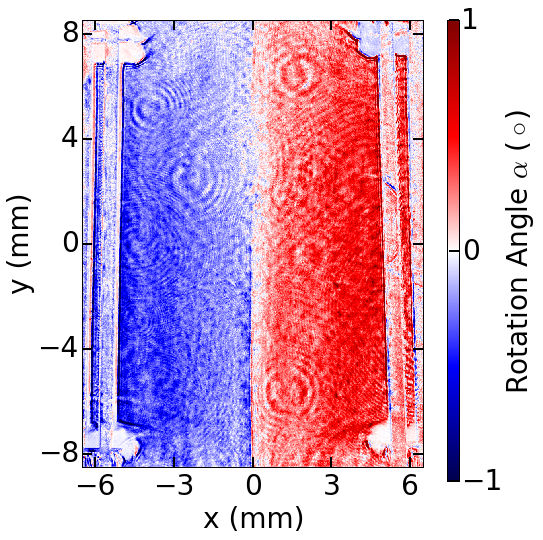

In [23]:
fig, ax=plt.subplots(figsize=(8,8))
far=s.plot_alpha_mm(ax=ax,clim=[-1,1])

ax.set_xlim([s.extent[0],s.extent[1]])
ax.set_ylim([s.extent[2],s.extent[3]])
ax.set_xlabel('x (mm)',fontsize=28)
ax.set_ylabel('y (mm)',fontsize=28)

ax.set_xticks([-6,-3,0,3, 6])
ax.set_yticks([-8,-4,0,4,8])

ax.tick_params(labelsize=28, pad=5, length=10, width=2)

cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])#l,b,w,h
cbar_ax.tick_params(labelsize=28, pad=5, length=10, width=2)
fig.colorbar(far, cax=cbar_ax, ticks=[-1,0,1])
cbar_ax.set_ylabel(r'Rotation Angle $\alpha$ ($\circ$)',fontsize=28)

In [24]:
fig.savefig('s0513_15 alpha map hi res.pdf', dpi=300)

In [25]:
cd ".."

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat


In [26]:
s0513_15_far=FaradayMap(s0513_15_pol,"s0513_15 IR side on image registration (2).jpg", "s0513_15 neL side on.txt")

In [27]:
s=s0513_15_far
s.scale_and_crop()
s.register()

C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:230: RuntimeWarning: divide by zero encountered in true_divide
  self.B=5.99e18*self.pm.alpha/self.I1T
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:230: RuntimeWarning: overflow encountered in true_divide
  self.B=5.99e18*self.pm.alpha/self.I1T
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:230: RuntimeWarning: invalid value encountered in true_divide
  self.B=5.99e18*self.pm.alpha/self.I1T


In [28]:
B_av=np.mean(s.B[1200:1400,1380:1980], axis=0)
y_B=np.arange(0,B_av.size)/s0513_15_pol.scale
from lmfit import Model
def Harris(y, y0, B0, L,C):
    return B0*np.tanh((y-y0)/L)+C
hm=Model(Harris, independent_vars='y')
hm.set_param_hint('B0', value = 2)
hm.set_param_hint('y0', value = 0)
hm.set_param_hint('L', value = 0.25)
hm.set_param_hint('C', value = 0)
res=hm.fit(B_av, y=y_B)

 - Adding parameter for hint "B0"
 - Adding parameter for hint "y0"
 - Adding parameter for hint "L"
 - Adding parameter for hint "C"
 - Adding parameter "y0"
 - Adding parameter "B0"
 - Adding parameter "L"
 - Adding parameter "C"


In [29]:
y_Bc=y_B-res.best_values['y0']
B=B_av-res.best_values['C']
hm=Model(Harris, independent_vars='y')
hm.set_param_hint('B0', value = 2)
hm.set_param_hint('y0', value = 0)
hm.set_param_hint('L', value = 0.25)
hm.set_param_hint('C', value = 0)
res=hm.fit(B, y=y_Bc)

 - Adding parameter for hint "B0"
 - Adding parameter for hint "y0"
 - Adding parameter for hint "L"
 - Adding parameter for hint "C"
 - Adding parameter "y0"
 - Adding parameter "B0"
 - Adding parameter "L"
 - Adding parameter "C"


In [30]:
n_av=np.mean(s.I1T[1200:1400,1380:1980], axis=0)

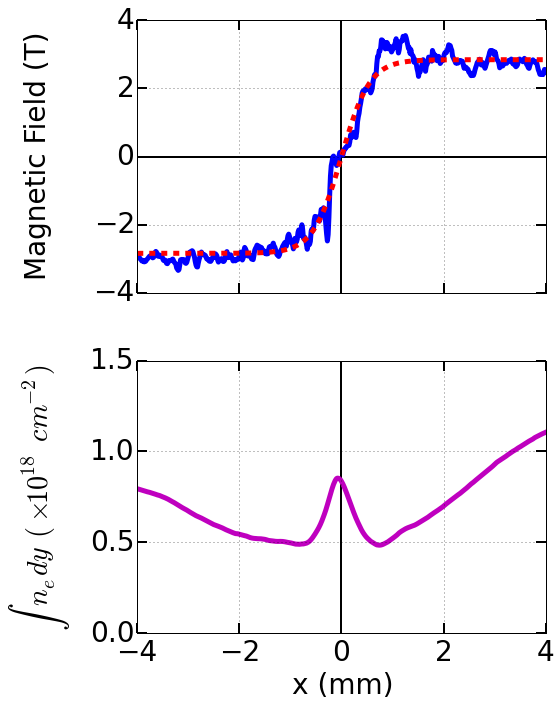

In [31]:
fig, (ax1,ax2)= plt.subplots(2, sharex=True, figsize=(8,10))

ax1.plot([-4, 4], [0, 0], color='k', linewidth=2)
ax1.plot([0, 0], [-4, 4], color='k', linewidth=2)
ax2.plot([0, 0], [0, 2], color='k', linewidth=2)

ax1.plot(y_Bc,B, label='Magnetic Field', color='b', lw=5)
ax1.plot(y_Bc,res.best_fit, label='B Fitted', color='red', lw=5, ls='--')

ax2.plot(y_Bc,n_av/1e18, lw=5, color='m', label='Electron Density')

ax1.set_xlim([-4,4])
ax1.set_xticks(np.arange(-4,4+1,2))
ax2.set_xlabel('x (mm)', fontsize=28)
ax1.set_ylim([-4,4])
ax1.set_yticks([-4,-2,0,2,4])
ax1.set_ylabel('Magnetic Field (T)',fontsize=28)

ax2.set_ylim([0,1.5])
ax2.set_yticks([0,0.5,1,1.5])

ax1.get_yaxis().set_label_coords(-0.21,0.5)
ax2.get_yaxis().set_label_coords(-0.16,0.5)

fig.subplots_adjust(hspace=0.8)


ax2.set_ylabel(r'$\int \,n_e dy \,(\times 10^{18}\,cm^{-2})$',fontsize=28)
ax1.tick_params(labelsize=28, pad=5, length=10, width=2)
ax2.tick_params(labelsize=28, pad=5, length=10, width=2)
#ax1.set_title(r's0513_15: $B$ and $n_e$',fontsize=40, y=1.02)
ax1.grid()
ax2.grid()
fig.tight_layout()

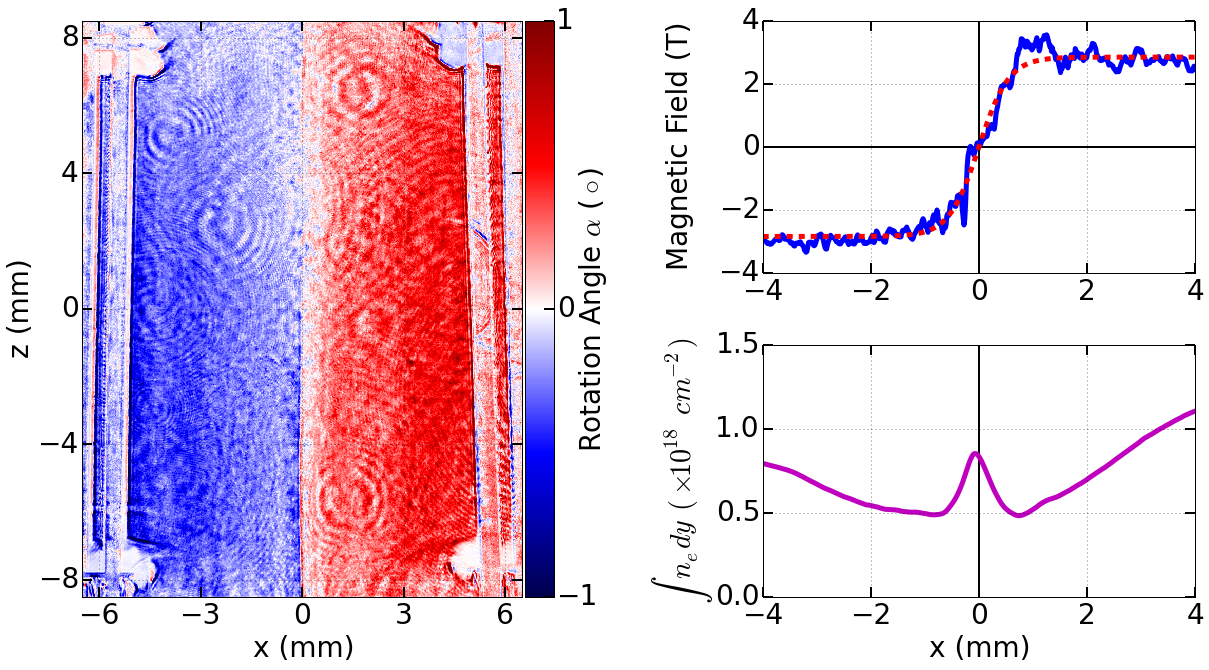

In [32]:
s=s0513_15_pol

fig=plt.figure(figsize=(20,10))

ax=fig.add_axes([0.0, 0.10, 0.4, 0.8])#l,b,w,h

far=s.plot_alpha_mm(ax=ax,clim=[-1,1])

ax.set_xlim([s.extent[0],s.extent[1]])
ax.set_ylim([s.extent[2],s.extent[3]])
ax.set_xlabel('x (mm)',fontsize=28)
ax.set_ylabel('z (mm)',fontsize=28)

ax.set_xticks([-6,-3,0,3, 6])
ax.set_yticks([-8,-4,0,4,8])

ax.tick_params(labelsize=28, pad=5, length=10, width=2)

ax.grid()

cbar_ax = fig.add_axes([0.355, 0.10, 0.02, 0.8])#left,bottom,width,height
cbar_ax.tick_params(labelsize=28, pad=5, length=10, width=2)
fig.colorbar(far, cax=cbar_ax, ticks=[-1,0,1])
cbar_ax.set_ylabel(r'Rotation Angle $\alpha$ ($\circ$)',fontsize=28)

cbar_ax.get_yaxis().set_label_coords(1.8,0.5)


ax2=fig.add_axes([0.52, 0.10, 0.3, 0.35])
ax1=fig.add_axes([0.52, 0.55, 0.3, 0.35], sharex=ax2)#left,bottom,width,height

ax1.plot([-4, 4], [0, 0], color='k', linewidth=2)
ax1.plot([0, 0], [-4, 4], color='k', linewidth=2)
ax2.plot([0, 0], [0, 2], color='k', linewidth=2)

ax1.plot(y_Bc,B, label='Magnetic Field', color='b', lw=5)
ax1.plot(y_Bc,res.best_fit, label='B Fitted', color='red', lw=5, ls='--')

ax2.plot(y_Bc,n_av/1e18, lw=5, color='m', label='Electron Density')

ax1.set_xlim([-4,4])
ax1.set_xticks(np.arange(-4,4+1,2))
ax2.set_xlabel('x (mm)', fontsize=28)
ax1.set_ylim([-4,4])
ax1.set_yticks([-4,-2,0,2,4])
ax1.set_ylabel('Magnetic Field (T)',fontsize=28)

ax2.set_ylim([0,1.5])
ax2.set_yticks([0,0.5,1,1.5])

ax1.get_yaxis().set_label_coords(-0.16,0.5)
ax2.get_yaxis().set_label_coords(-0.11,0.5)

fig.subplots_adjust(hspace=0.8)


ax2.set_ylabel(r'$\int \,n_e dy \,(\times 10^{18}\,cm^{-2})$',fontsize=28)
ax1.tick_params(labelsize=28, pad=5, length=10, width=2)
ax2.tick_params(labelsize=28, pad=5, length=10, width=2)
#ax1.set_title(r's0513_15: $B$ and $n_e$',fontsize=40, y=1.02)
ax1.grid()
ax2.grid()
#fig.tight_layout()

In [ ]:
fig.savefig('s0513_15 faraday analysis.pdf', dpi=300, bbox_inches='tight')